#1. Libraries Import

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


#2. Load Data

In [ ]:
train_data = pd.read_csv("/content/Train-1617360447408-1660719685476.csv")
test_data = pd.read_csv("/content/test-1617360461595-1660719701431.csv")

train_data.head()
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66587 entries, 0 to 66586
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               66587 non-null  int64  
 1   encounter_id        66587 non-null  int64  
 2   patient_id          66587 non-null  int64  
 3   race                66587 non-null  object 
 4   gender              66587 non-null  object 
 5   age                 66587 non-null  object 
 6   weight              66587 non-null  object 
 7   time_in_hospital    66587 non-null  int64  
 8   medical_specialty   66587 non-null  object 
 9   num_lab_procedures  66587 non-null  int64  
 10  num_procedures      66587 non-null  int64  
 11  num_medications     66587 non-null  int64  
 12  number_outpatient   66587 non-null  int64  
 13  number_emergency    66587 non-null  int64  
 14  number_inpatient    66587 non-null  int64  
 15  diag_1              66587 non-null  object 
 16  diag

In [ ]:
# Check duplicates first
print("Duplicate rows:", train_data.duplicated().sum())

# Remove duplicates
train_data = train_data.drop_duplicates()

print("After removal:", train_data.shape)


Duplicate rows: 17676
After removal: (48911, 49)


#3 Replace Invalid Values

In [ ]:
train_data['race'] = train_data['race'].replace('?', np.nan).fillna(train_data['race'].mode()[0])
test_data['race']  = test_data['race'].replace('?', np.nan).fillna(train_data['race'].mode()[0])


#Handle Missing Values

In [ ]:
# Separate column types from TRAIN
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train_data.select_dtypes(exclude=['int64', 'float64']).columns

# Remove target if present
if 'readmitted' in num_cols:
    num_cols = num_cols.drop('readmitted')

In [ ]:
num_imputer = SimpleImputer(strategy='median')

# Fit on TRAIN
train_data[num_cols] = num_imputer.fit_transform(train_data[num_cols])

# Transform TEST
test_data[num_cols] = num_imputer.transform(test_data[num_cols])


In [ ]:
cat_imputer = SimpleImputer(strategy='most_frequent')

# Fit on TRAIN
train_data[cat_cols] = cat_imputer.fit_transform(train_data[cat_cols])

# Transform TEST
test_data[cat_cols] = cat_imputer.transform(test_data[cat_cols])


In [ ]:
print("Train missing values:", train_data.isnull().sum().sum())
print("Test missing values :", test_data.isnull().sum().sum())


Train missing values: 0
Test missing values : 0


In [ ]:
train_data.columns
test_data.columns

Index(['index', 'encounter_id', 'patient_id', 'race', 'gender', 'age',
       'weight', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'diag_4', 'diag_5', 'number_diagnoses', 'X1', 'X2', 'X3', 'X4', 'X5',
       'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16',
       'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'change',
       'diabetesMed'],
      dtype='object')

#Remove Unnecessary Columns

In [ ]:
drop_cols = ['weight', 'X1', 'X2']

train_data = train_data.drop(columns=drop_cols, errors='ignore')
test_data  = test_data.drop(columns=drop_cols, errors='ignore')


#Clean medical_specialty properly

In [ ]:
categorical_cols = ['race', 'gender', 'medical_specialty']
numerical_cols = ['num_lab_procedures', 'num_procedures', 'num_medications']


#Clean medical_specialty properly

In [ ]:
# Replace '?' and empty strings with NaN
for df in [train_data, test_data]:
    df['medical_specialty'] = df['medical_specialty'].replace('?', np.nan)
    df['medical_specialty'] = df['medical_specialty'].replace(r'^\s*$', np.nan, regex=True)


In [ ]:
# Fill NaN using TRAIN mode only
med_mode = train_data['medical_specialty'].mode()[0]

train_data['medical_specialty'] = train_data['medical_specialty'].fillna(med_mode)
test_data['medical_specialty']  = test_data['medical_specialty'].fillna(med_mode)


#Clean categorical columns

In [ ]:
for col in categorical_cols:
    # Replace empty with NaN
    train_data[col] = train_data[col].replace(r'^\s*$', np.nan, regex=True)
    test_data[col]  = test_data[col].replace(r'^\s*$', np.nan, regex=True)

    # Fill NaN using TRAIN mode
    mode_val = train_data[col].mode()[0]
    train_data[col] = train_data[col].fillna(mode_val)
    test_data[col]  = test_data[col].fillna(mode_val)

    # Normalize text
    train_data[col] = train_data[col].astype(str).str.strip().str.lower()
    test_data[col]  = test_data[col].astype(str).str.strip().str.lower()


#Clean numerical columns (median from TRAIN)

In [ ]:
for col in numerical_cols:
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')
    test_data[col]  = pd.to_numeric(test_data[col], errors='coerce')

    median_val = train_data[col].median()

    train_data[col] = train_data[col].fillna(median_val)
    test_data[col]  = test_data[col].fillna(median_val)


In [ ]:
print("Train missing values:", train_data.isna().sum().sum())
print("Test missing values:", test_data.isna().sum().sum())


Train missing values: 0
Test missing values: 0


#Encoding Features

#Unknown Diagnoses Count

In [ ]:
import string

def clean_diagnosis_columns(train_data, test_data):
    diag_cols = ['diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5']

    for col in diag_cols:
        # ---- learn mode from TRAIN only ----
        mode_value = (
            train_data[~train_data[col].isin(['?', None])][col]
            .dropna()
            .mode()[0]
        )

        # ---- replace '?' with mode ----
        train_data[col] = train_data[col].replace('?', mode_value)
        test_data[col]  = test_data[col].replace('?', mode_value)

        # ---- remove symbols ----
        train_data[col] = train_data[col].apply(
            lambda x: ''.join(c for c in str(x) if c not in string.punctuation)
        )
        test_data[col] = test_data[col].apply(
            lambda x: ''.join(c for c in str(x) if c not in string.punctuation)
        )

    return train_data, test_data


In [ ]:
train_data, test_data = clean_diagnosis_columns(train_data, test_data)


In [ ]:
diag_cols = ['diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5']

for col in diag_cols:
    train_symbols = train_data[col].apply(
        lambda x: sum(1 for c in str(x) if c in string.punctuation)
    ).sum()

    test_symbols = test_data[col].apply(
        lambda x: sum(1 for c in str(x) if c in string.punctuation)
    ).sum()

    print(f"{col} → TRAIN symbols: {train_symbols}, TEST symbols: {test_symbols}")


diag_1 → TRAIN symbols: 0, TEST symbols: 0
diag_2 → TRAIN symbols: 0, TEST symbols: 0
diag_3 → TRAIN symbols: 0, TEST symbols: 0
diag_4 → TRAIN symbols: 0, TEST symbols: 0
diag_5 → TRAIN symbols: 0, TEST symbols: 0


#Age Midpoints

In [ ]:
age_map = {
    '[0-10)':5,'[10-20)':15,'[20-30)':25,'[30-40)':35,
    '[40-50)':45,'[50-60)':55,'[60-70)':65,'[70-80)':75,
    '[80-90)':85,'[90-100)':95
}

train_data['age'] = train_data['age'].map(age_map)
test_data['age'] = test_data['age'].map(age_map)


#One-Hot Encode Categorical Features

In [ ]:
# Create working copies
copyData  = train_data.copy()
copyData1 = test_data.copy()


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 1️⃣ Detect categorical columns
obj_cols = copyData.select_dtypes(include='object').columns.tolist()

# 2️⃣ Label Encoding safely on Train + Test
for col in obj_cols:
    le = LabelEncoder()

    combined = pd.concat(
        [copyData[col].astype(str),
         copyData1[col].astype(str)],
        axis=0
    )

    le.fit(combined)

    copyData[col]  = le.transform(copyData[col].astype(str))
    copyData1[col] = le.transform(copyData1[col].astype(str))


In [ ]:
# TRAIN
X_train = copyData.drop(columns=['readmitted'])
y_train = copyData['readmitted']

# TEST (no label)
X_test = copyData1.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape)


(48911, 46) (48911,)
(16647, 46)


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)

rf_f1 = f1_score(y_train, y_train_pred_rf)
print("Random Forest F1 (Train):", rf_f1 * 100)


Random Forest F1 (Train): 73.32299425525873


In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

y_train_pred_lr = lr.predict(X_train)

print(
    "Logistic Regression F1 (Train):",
    f1_score(y_train, y_train_pred_lr) * 100
)


Logistic Regression F1 (Train): 53.42990674906417


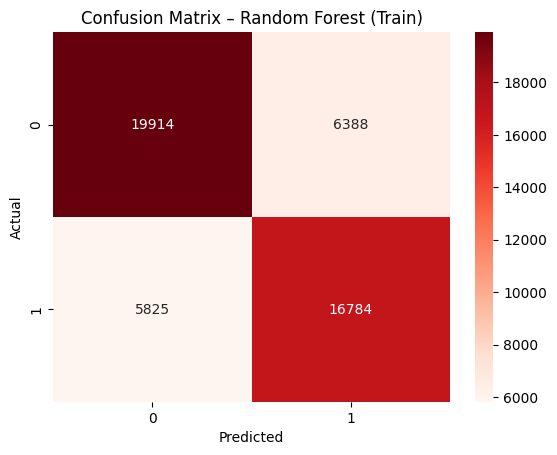

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_train, y_train_pred_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix – Random Forest (Train)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [ ]:
num_cols = train_data.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('readmitted')

scaler = StandardScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
test_data[num_cols] = scaler.transform(test_data[num_cols])


#Splitting Target & Features

In [ ]:
X_train_full = train_data.drop(columns=['readmitted'])
y_train_full = train_data['readmitted']


#Model Training

In [ ]:
X_train = train_data.drop(columns=['readmitted'])
y_train = train_data['readmitted']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (48911, 46)
y_train shape: (48911,)


In [ ]:
leak_cols = ['index', 'encounter_id', 'patient_id']

train_data.drop(columns=leak_cols, inplace=True, errors='ignore')
test_data.drop(columns=leak_cols, inplace=True, errors='ignore')


In [ ]:
X_test_aligned = test_data.reindex(
    columns=X_train_full.columns,
    fill_value=0
)


In [ ]:
X_train_full.reset_index(drop=True, inplace=True)
X_test_aligned.reset_index(drop=True, inplace=True)


In [ ]:
X_test = test_data.reindex(columns=X_train.columns, fill_value=0)
print("X_test shape:", X_test.shape)


X_test shape: (16647, 46)


#Random Forest Classifier

#HistGradientBoostingClassifier (Faster Boosting)

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    max_iter=120,
    max_depth=3,
    max_bins=64,
    learning_rate=0.1,
    random_state=42
)

hgb.fit(X_train, y_train)

hgb_preds = hgb.predict(X_test)
hgb_probs = hgb.predict_proba(X_test)[:, 1]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Detect all object columns
obj_cols = X_train.select_dtypes(include='object').columns.tolist()
print("Categorical columns to encode:", obj_cols)

# Apply LabelEncoder on each
for col in obj_cols:
    le = LabelEncoder()
    combined = pd.concat([X_train[col].astype(str), X_test[col].astype(str)], axis=0)
    le.fit(combined)

    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col]  = le.transform(X_test[col].astype(str))

# Check
print(X_train.dtypes[obj_cols])


Categorical columns to encode: ['race', 'gender', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'change', 'diabetesMed']
race                 int64
gender               int64
medical_specialty    int64
diag_1               int64
diag_2               int64
diag_3               int64
diag_4               int64
diag_5               int64
X3                   int64
X4                   int64
X5                   int64
X6                   int64
X7                   int64
X8                   int64
X9                   int64
X10                  int64
X11                  int64
X12                  int64
X13                  int64
X14                  int64
X15                  int64
X16                  int64
X17                  int64
X18                  int64
X19                  int64
X20                  int6

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# -----------------------------
# Ensure X_train and X_test are defined
# Example:
# X_train = train_data.drop(columns=['readmitted'])
# y_train = train_data['readmitted']
# X_test = test_data.copy()
# -----------------------------

# Encode all remaining categorical columns
obj_cols = X_train.select_dtypes(include='object').columns.tolist()

for col in obj_cols:
    le = LabelEncoder()
    combined = pd.concat([X_train[col].astype(str), X_test[col].astype(str)], axis=0)
    le.fit(combined)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col]  = le.transform(X_test[col].astype(str))

# Initialize RandomForest
rf = RandomForestClassifier(
    n_estimators=150,   # reduce trees if RAM limited
    max_depth=12,       # limit depth
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Fit model on full training data
rf.fit(X_train, y_train)

#  Predict on test data (0 or 1)
test_preds = rf.predict(X_test)

# Optional: probabilities
# test_probs = rf.predict_proba(X_test)[:, 1]
# test_preds = (test_probs >= 0.5).astype(int)

# Save predictions
output = X_test.copy()
output['readmitted_prediction'] = test_preds
output.to_csv("Readmission_predictions.csv", index=False)

print("✅ RandomForest predictions completed with 0/1 output")


✅ RandomForest predictions completed with 0/1 output


In [ ]:
X_train_full.columns


Index(['index', 'encounter_id', 'patient_id', 'race', 'gender', 'age',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'diag_4', 'diag_5', 'number_diagnoses', 'X3', 'X4', 'X5', 'X6', 'X7',
       'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17',
       'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'change',
       'diabetesMed', 'unknown_diag_count'],
      dtype='object')

In [ ]:
# Assuming X_train and X_test are your cleaned datasets

# Convert float features to integers (rounding)
X_train_int = X_train.round(0).astype(int)
X_test_int = X_test.round(0).astype(int)

#  If target column exists
train_cleaned_int = X_train_int.copy()
train_cleaned_int['readmitted'] = y_train.astype(int)

# Save CSVs
train_cleaned_int.to_csv("cleaned_train_data_int.csv", index=False)
X_test_int.to_csv("cleaned_test_data_int.csv", index=False)

print(" Cleaned train and test saved with integer-only values")


✅ Cleaned train and test saved with integer-only values


#Graph

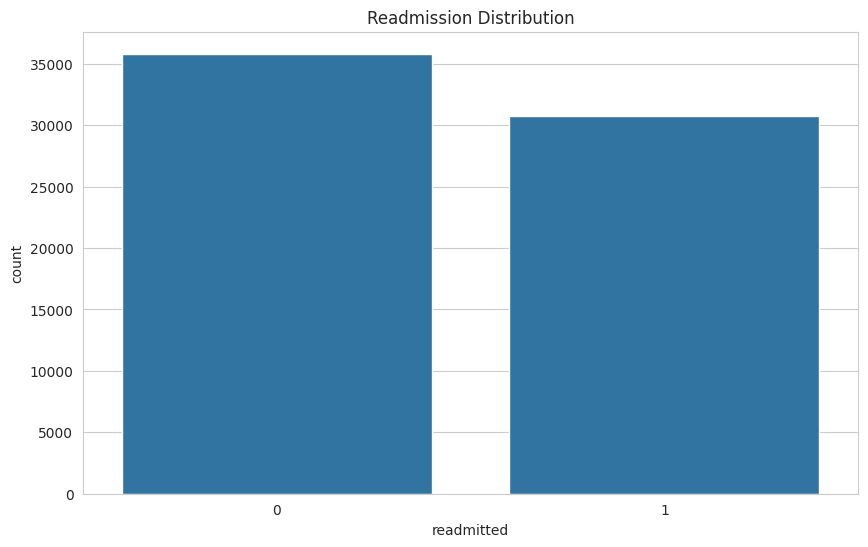

Readmission %:
 readmitted
0    53.79879
1    46.20121
Name: proportion, dtype: float64


In [ ]:
sns.countplot(x='readmitted', data=train_data)
plt.title("Readmission Distribution")
plt.show()

print("Readmission %:\n", train_data['readmitted'].value_counts(normalize=True)*100)


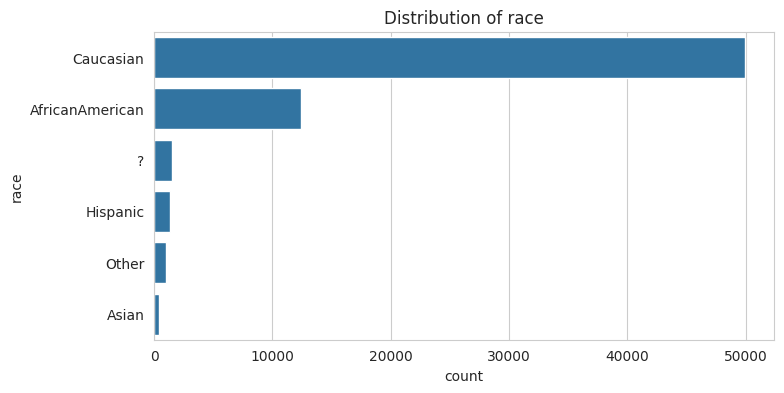

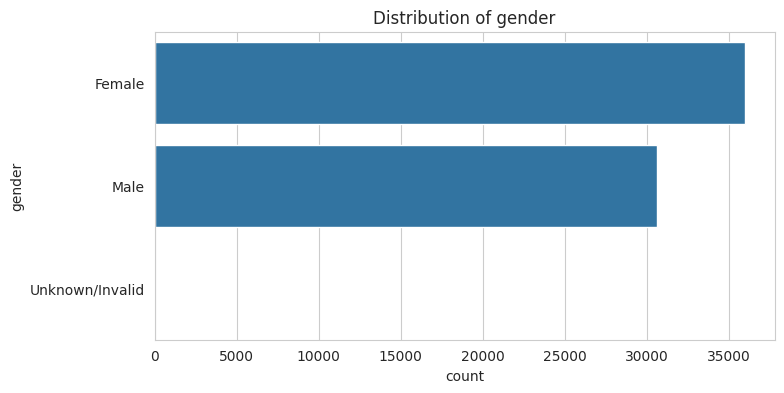

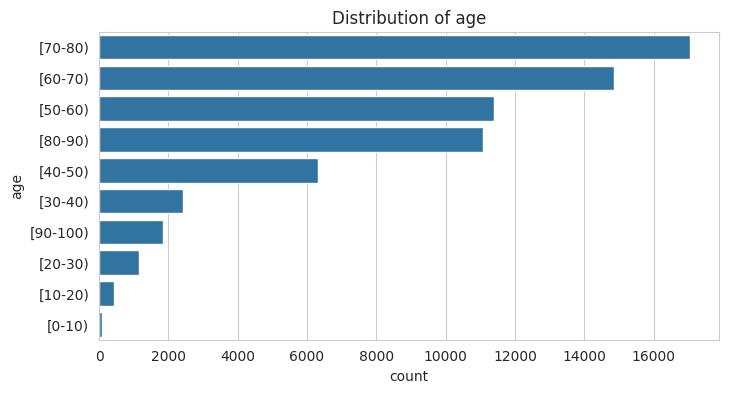

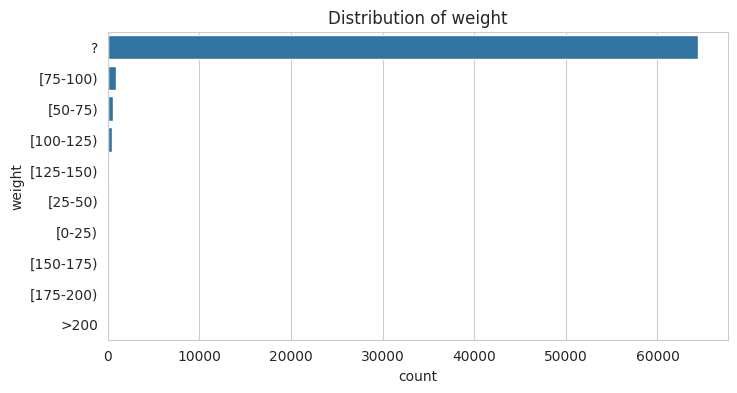

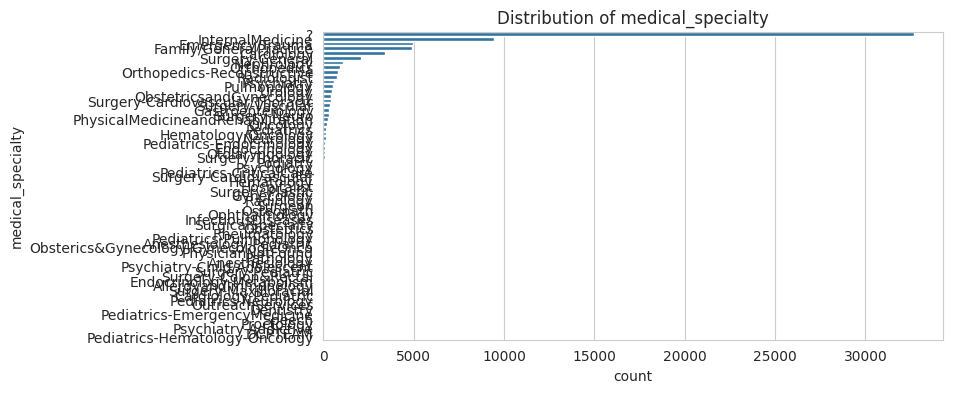

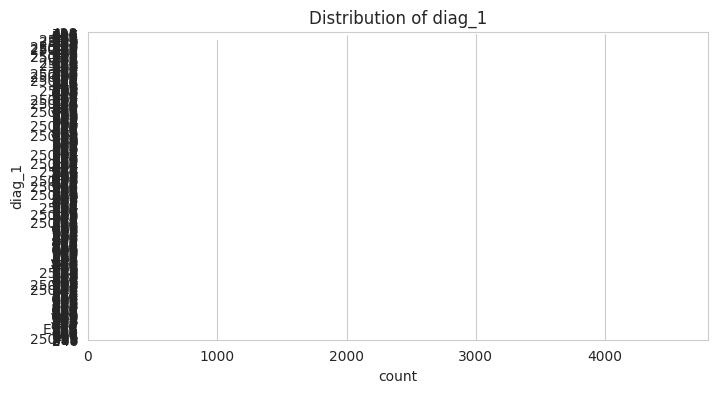

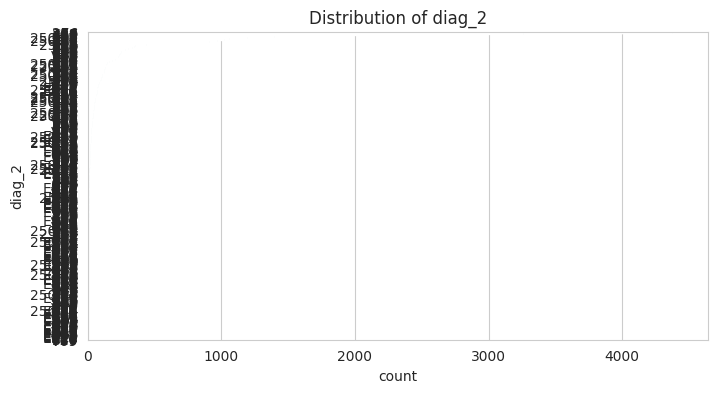

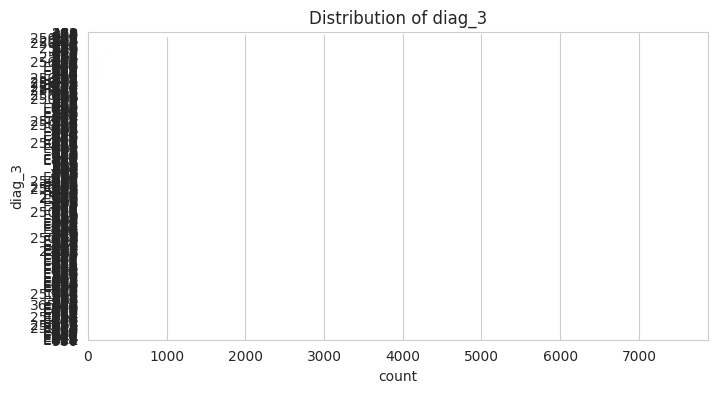

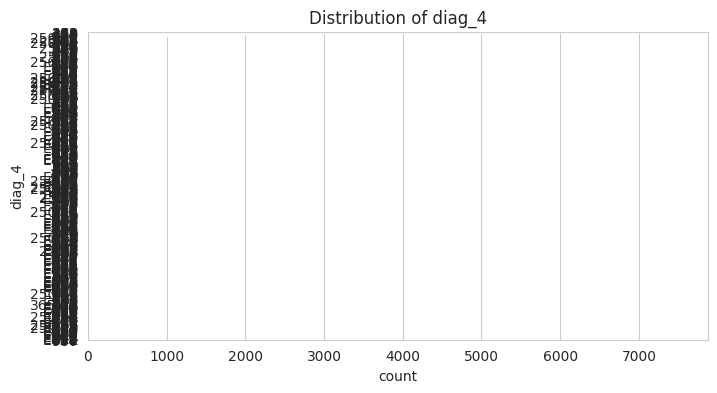

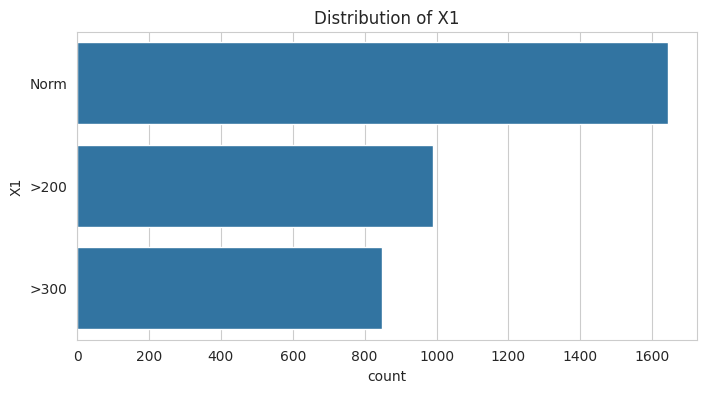

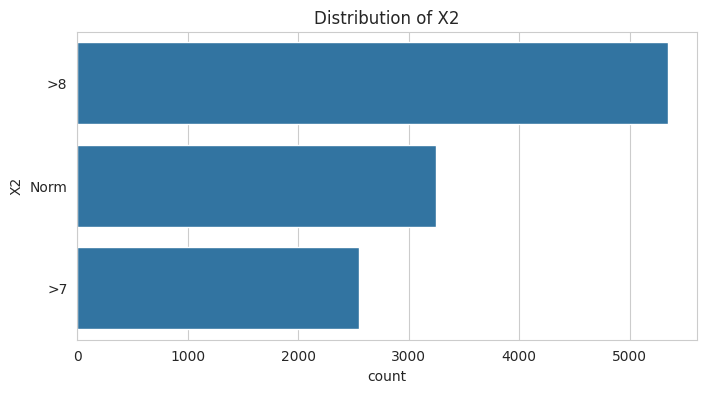

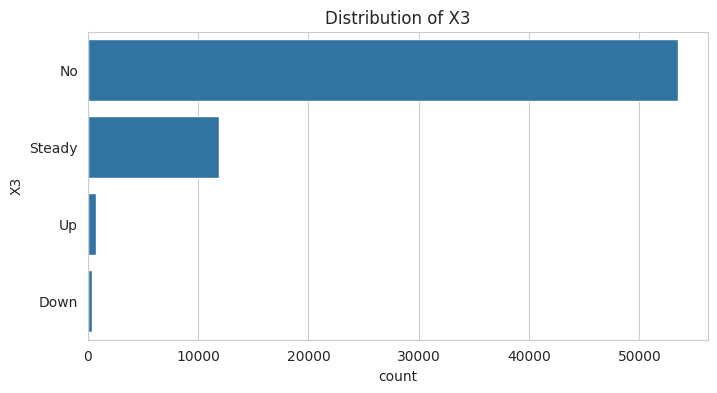

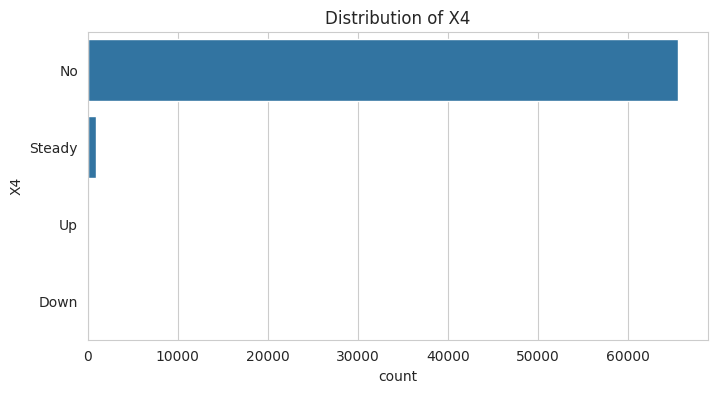

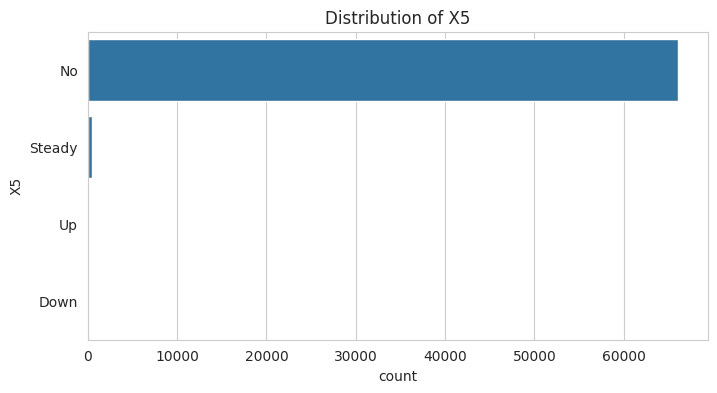

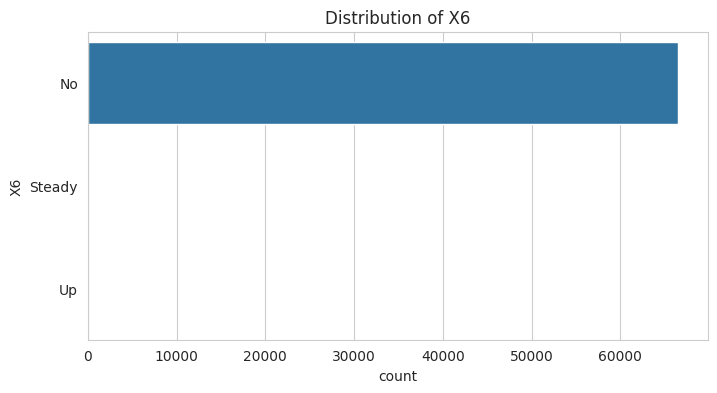

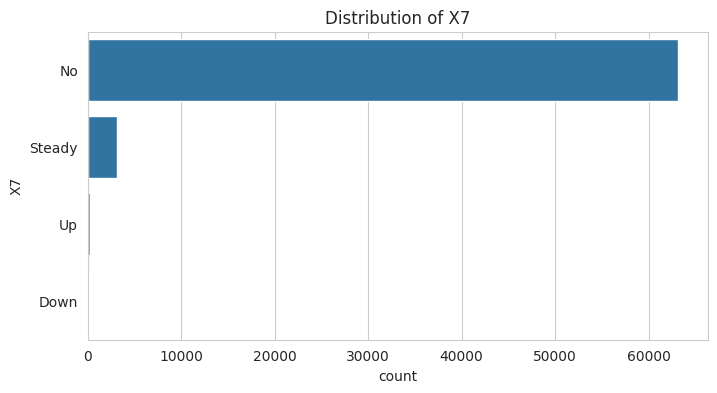

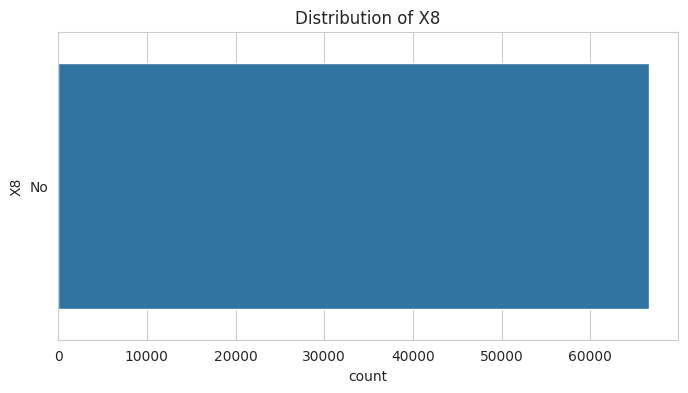

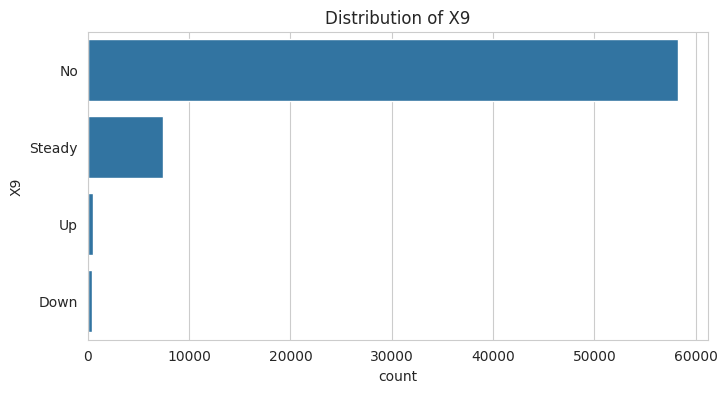

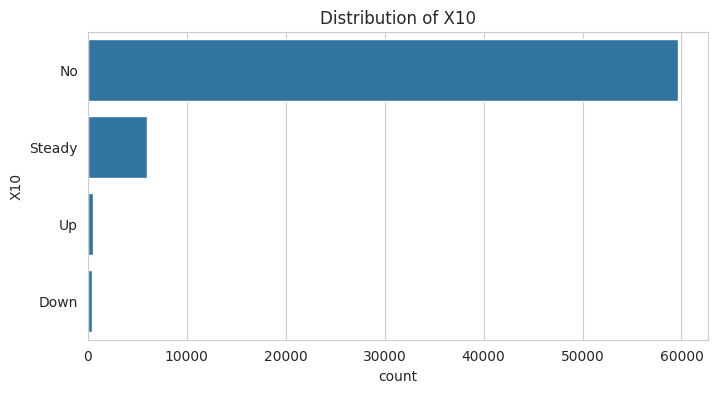

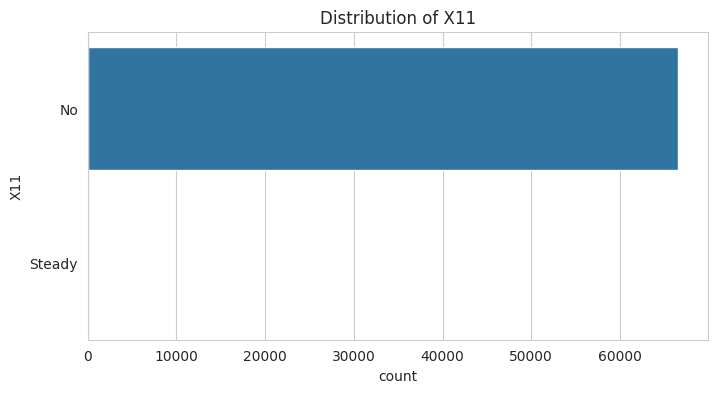

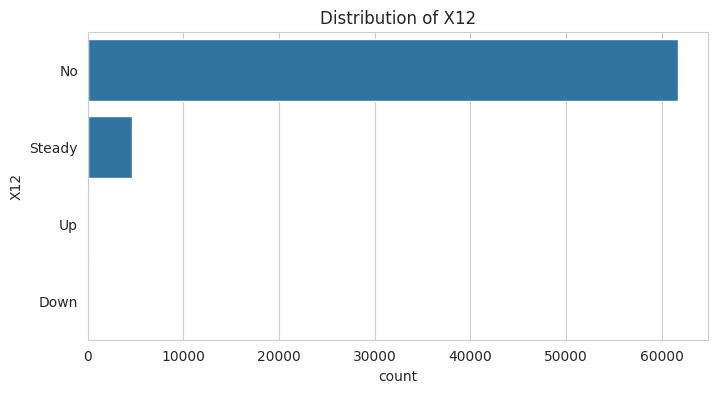

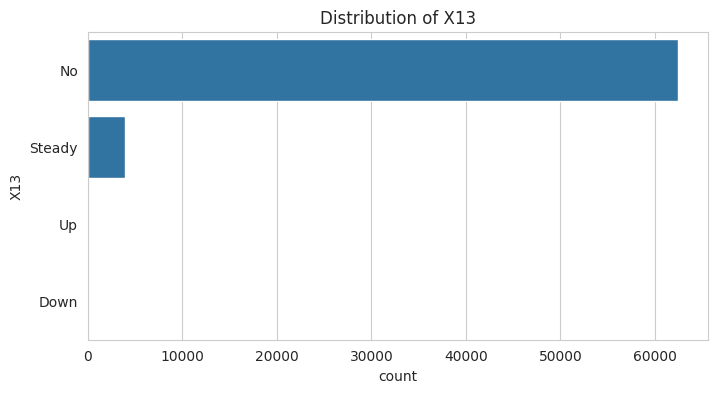

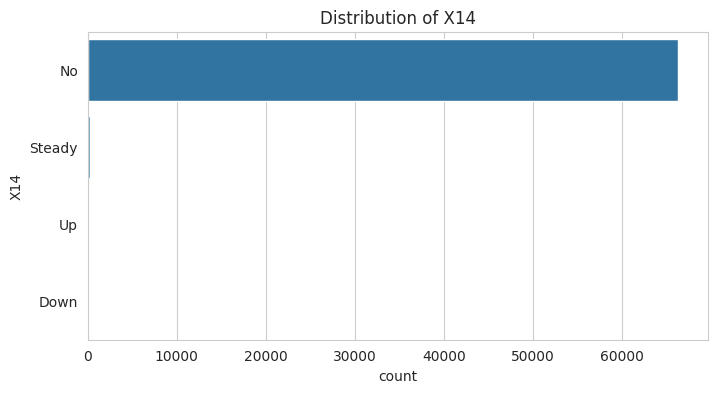

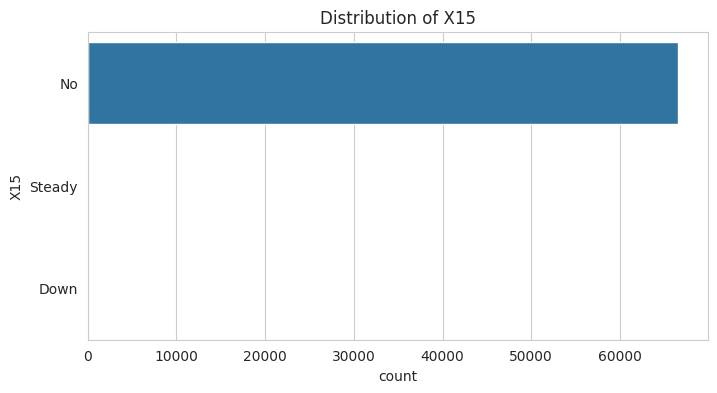

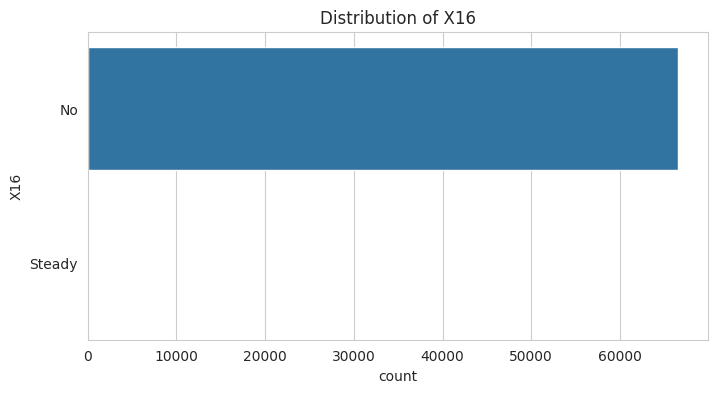

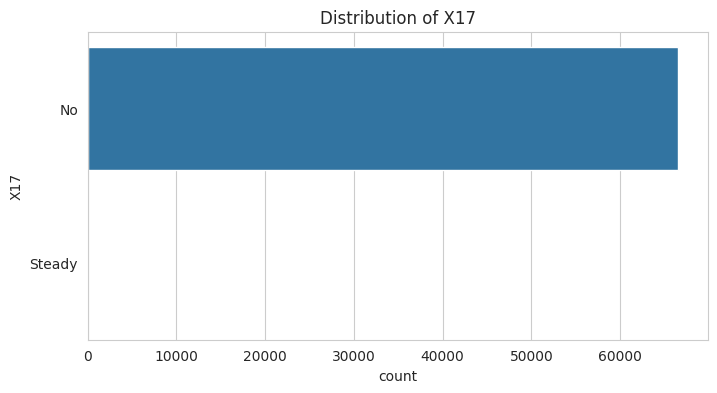

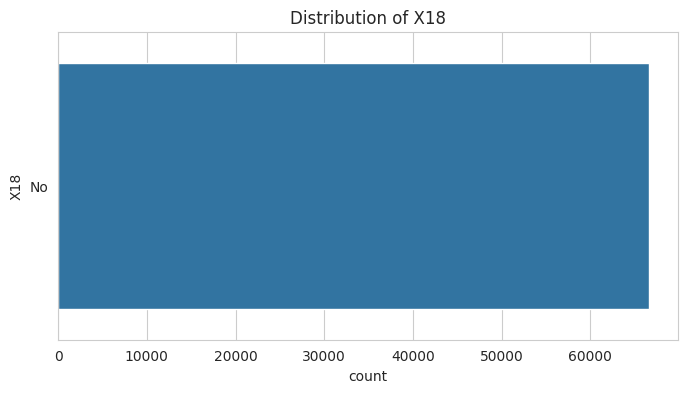

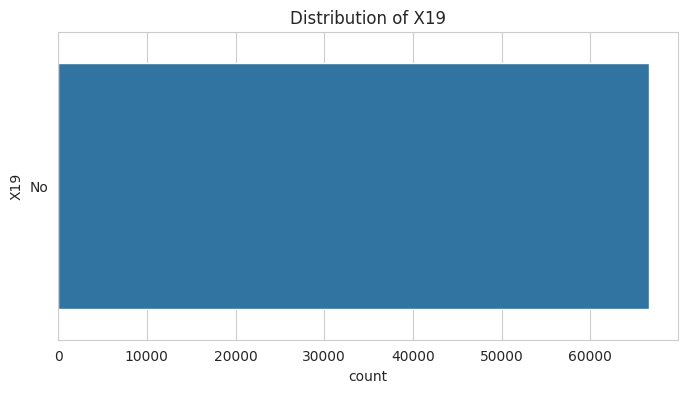

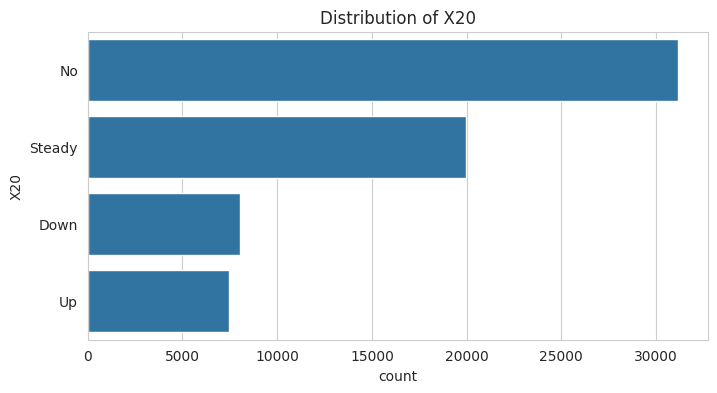

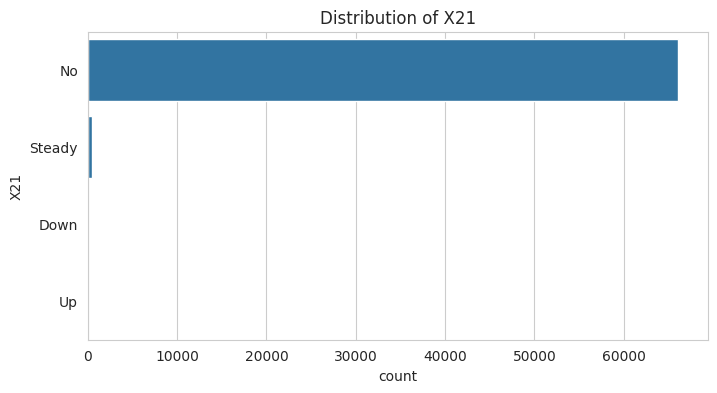

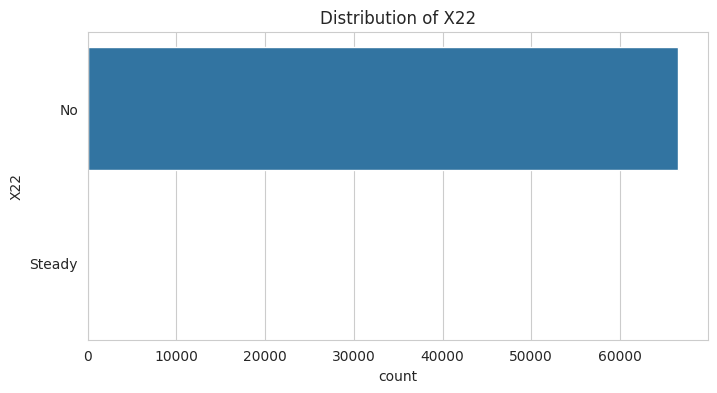

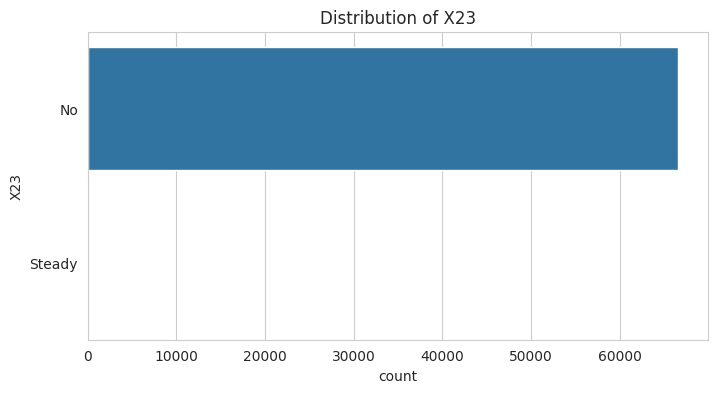

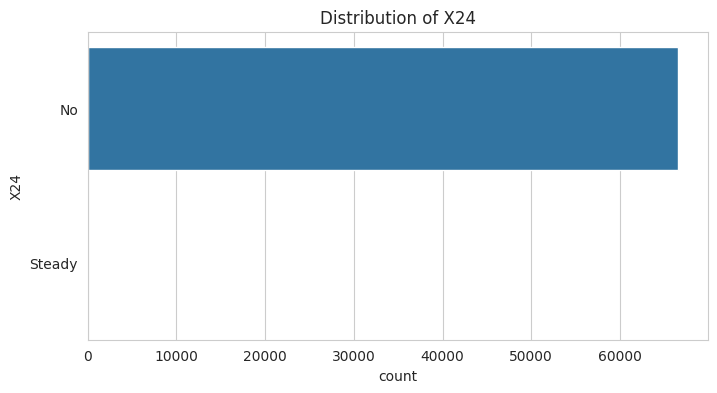

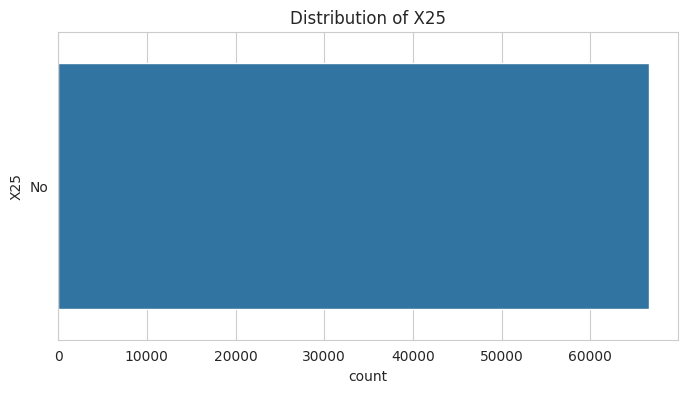

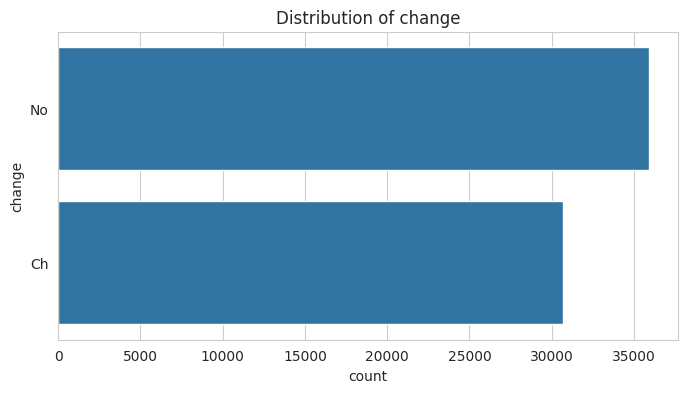

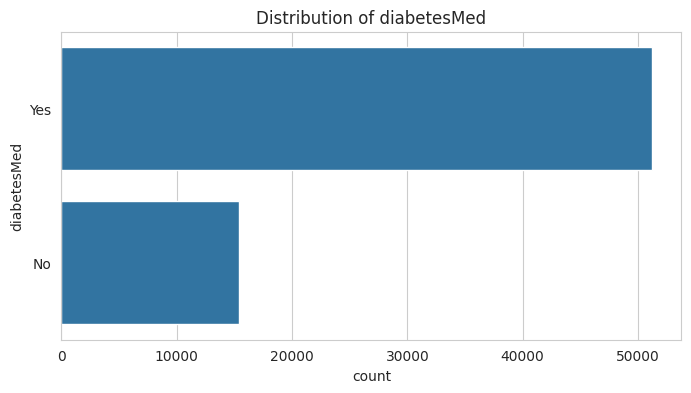

In [ ]:
cat_cols = train_data.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=train_data, order=train_data[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.show()


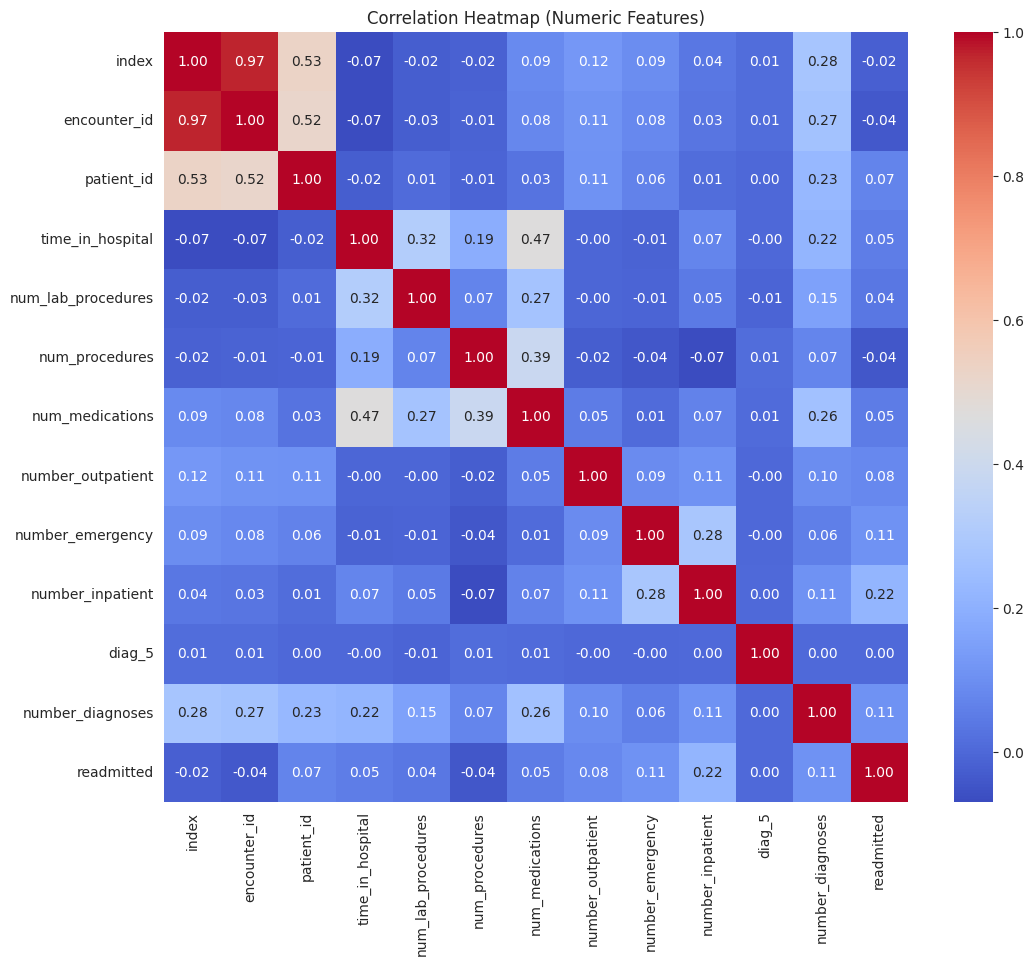

In [ ]:
# Automatically detect numeric columns in current DataFrame
num_cols = train_data.select_dtypes(include=np.number).columns.tolist()

# Now compute correlation
corr = train_data[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


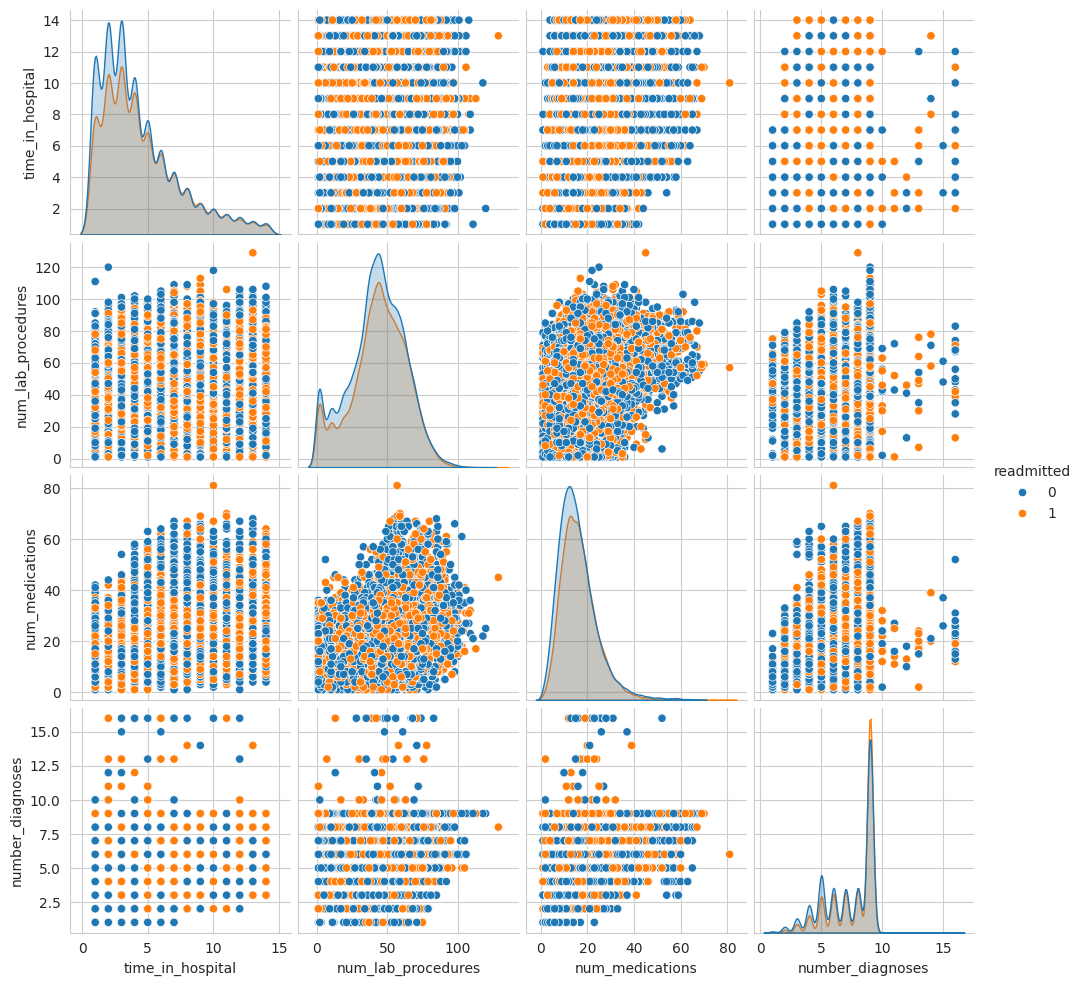

In [ ]:
important_num = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 'number_diagnoses']

sns.pairplot(train_data[important_num + ['readmitted']], hue='readmitted', diag_kind='kde')
plt.show()


In [ ]:
# Convert target to numeric
train_data['readmitted_num'] = train_data['readmitted'].map({
    'NO': 0,
    'YES': 1
})


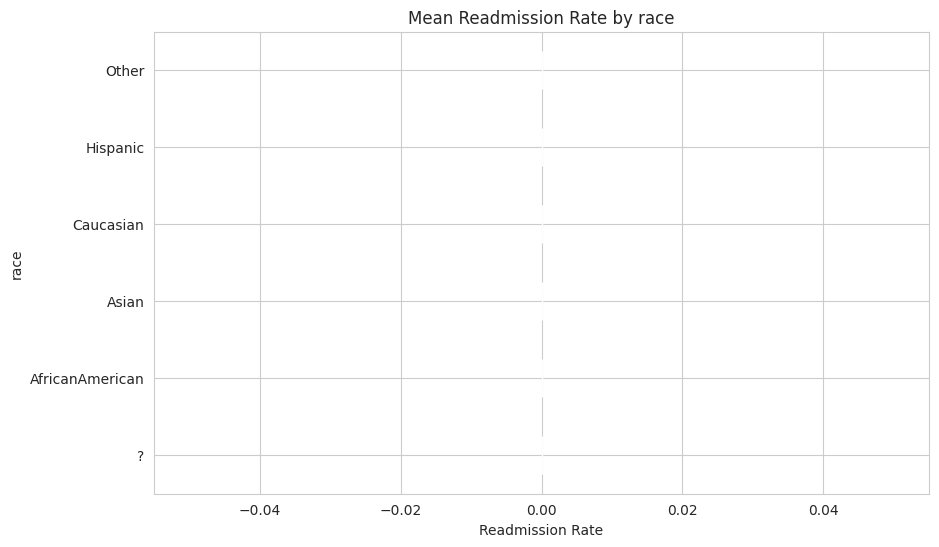

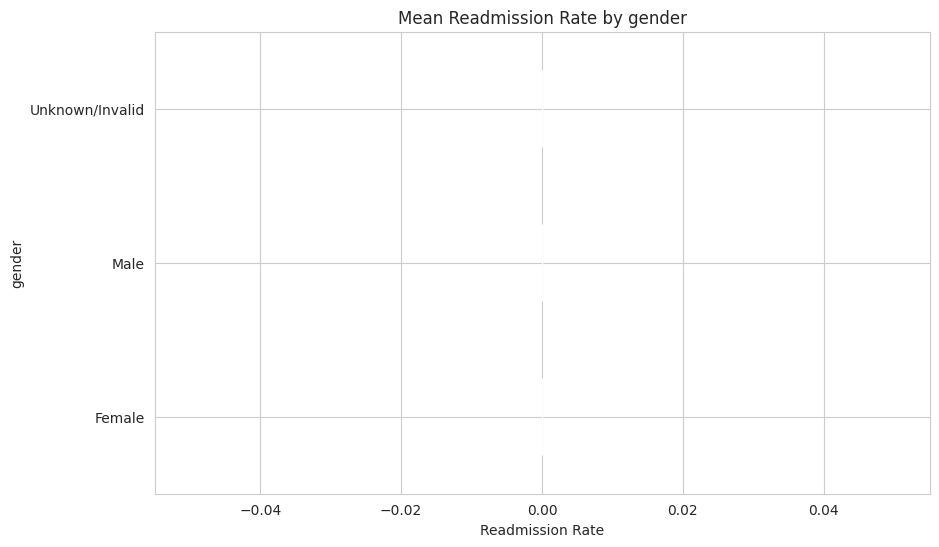

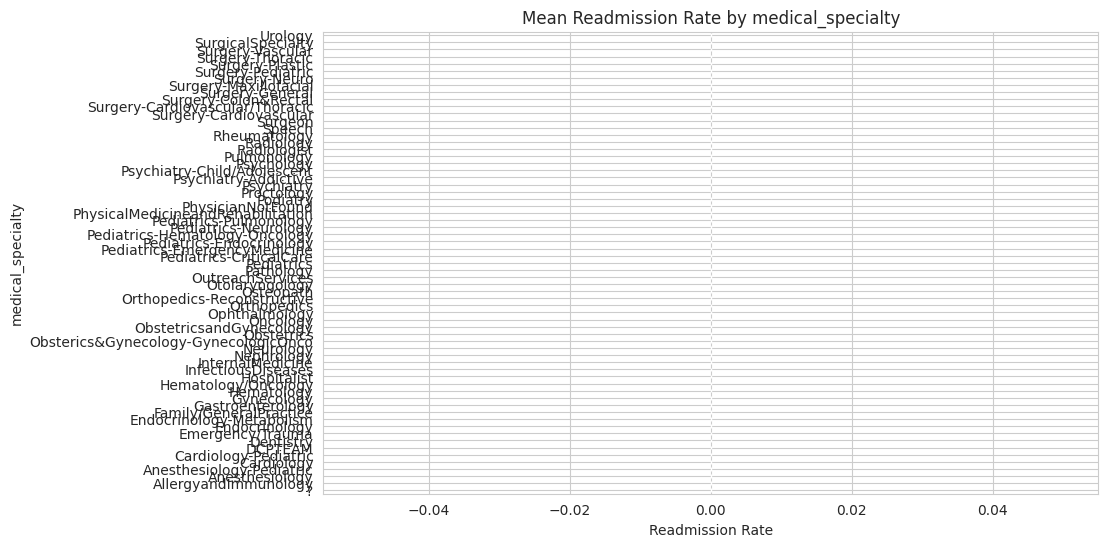

In [ ]:
top_cat = ['race', 'gender', 'medical_specialty']

for col in top_cat:
    ct = train_data.groupby(col)['readmitted_num'].mean().sort_values()
    ct.plot(kind='barh')
    plt.title(f"Mean Readmission Rate by {col}")
    plt.xlabel("Readmission Rate")
    plt.show()


In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.1 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok

In [ ]:
# 1️⃣ Import libraries
from sklearn.ensemble import RandomForestClassifier
import joblib

# 2️⃣ Define the model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# 3️⃣ Fit the model on your training data
# Make sure X_train and y_train are already defined
rf_model.fit(X_train, y_train)

# 4️⃣ Save the trained model
joblib.dump(rf_model, "readmission_model.pkl")

print("Model trained and saved successfully!")


Model trained and saved successfully!


In [ ]:
import joblib

# Example: RandomForest trained on your full train data
rf_model.fit(X_train, y_train)  # your trained model
joblib.dump(rf_model, "readmission_model.pkl")


['readmission_model.pkl']

In [ ]:
import streamlit as st
import joblib
import pandas as pd

# Load model
model = joblib.load("readmission_model.pkl")

st.title("Hospital Readmission Prediction")

# Example input fields
age = st.number_input("Age", min_value=0, max_value=100, value=50)
time_in_hospital = st.number_input("Time in Hospital", min_value=0, value=5)
num_lab_procedures = st.number_input("Number of Lab Procedures", min_value=0, value=10)
# ... add other features as needed

# Collect into DataFrame
input_data = pd.DataFrame({
    "age": [age],
    "time_in_hospital": [time_in_hospital],
    "num_lab_procedures": [num_lab_procedures],
    # ... add other features
})

if st.button("Predict"):
    prediction = model.predict(input_data)
    st.write("Predicted Readmission:", prediction[0])


2025-12-30 18:06:26.853 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-30 18:06:26.854 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-30 18:06:26.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-30 18:06:26.858 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-30 18:06:26.859 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-30 18:06:26.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-30 18:06:26.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-30 18:06:26.862 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!ngrok authtoken YOUR_AUTHTOKEN_HERE


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
%%writefile app.py
import streamlit as st

st.title("Hospital Readmission Prediction")
st.write("This is a placeholder app. Replace with your model and input fields.")


Writing app.py


In [ ]:
function ClickConnect(){
  console.log("Clicking");
  document.querySelector("#connect").click();
}
setInterval(ClickConnect,60000)


SyntaxError: invalid syntax (ipython-input-1463128524.py, line 1)

In [ ]:
from pyngrok import ngrok

!streamlit run app.py &
public_url = ngrok.connect(port='8501')
public_url





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.185.225.112:8501

  Stopping...


ERROR:pyngrok.process.ngrok:t=2025-12-30T18:17:48+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: YOUR_AUTHTOKEN_HERE\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-12-30T18:17:48+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: YOUR_AUTHTOKEN_HERE\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: YOUR_AUTHTOKEN_HERE\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n.

In [ ]:
!git config --global user.email "sachinsamuel287@gmail.com"
!git config --global user.name "Sachin"


In [ ]:
!git add Readmission_Prediction.ipynb

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git commit -m "Add Colab notebook"

fatal: not a git repository (or any of the parent directories): .git
